# Natural Language Processing with Disaster Tweets
**Predict which Tweets are about real disasters and which ones are not**

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter.

We have access to a dataset of 10,000 tweets that were hand classified.

# GOAL :
- The objective of this project is to determine if a Tweet is trully related to a natural disaster or not.
- We will be using a set of data from Twitter to perform our analysis and NLP processing.

#Import libraries

In [1]:
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import io
import os
import re
import shutil
import string
import tensorflow as tf
import warnings
import en_core_web_sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from plotly.subplots import make_subplots
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv("//content/train (1) (1).csv", error_bad_lines=False, encoding="utf-8")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print(f'the number of the rows and columns is : {data.shape}')

the number of the rows and columns is : (7613, 5)


# Data collection & EDA

In [4]:
print(data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


- On remarque que nous avons 2 533 valeurs manquantes dans la colonne location, on va retirer egalement les colonnes id, keyword et location qui nous apportent pas d'inforamtions importantes pour notre prédiction.

In [8]:
data["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

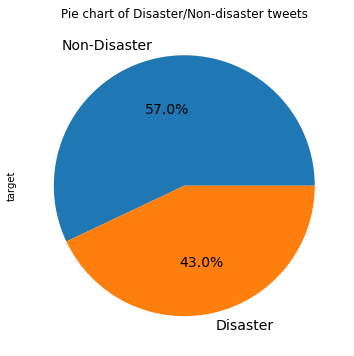

In [ ]:
data1=data.copy(deep=True)
pie1=pd.DataFrame(data1['target'].replace(1,'Disaster').replace(0,'Non-Disaster').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Distribution target variable: Disaster/Non-disaster tweets',y = 'target', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,6))

In [7]:
data.target.value_counts()/data.shape[0]

0    0.57034
1    0.42966
Name: target, dtype: float64

- le dataset semble légèrement déséquilibré concernant la variable cible.

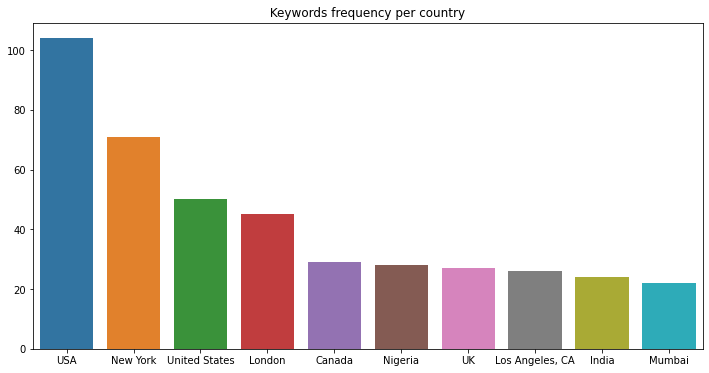

In [6]:
# Most common locations
plt.figure(figsize=(12,6))
sns.barplot(x=data.location.value_counts().head(10).index, y=data.location.value_counts().head(10).values)
plt.title(' Keywords frequency per country ')
plt.show()

- Nous pouvons voir que les États-Unis, Royaume-Uni,  ont le plus grand nombre de Tweets liés.

- Nous pouvons remarquer également que  Twitter est beaucoup plus utilisé dans les pays anglophones.

In [12]:
data["keyword"].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

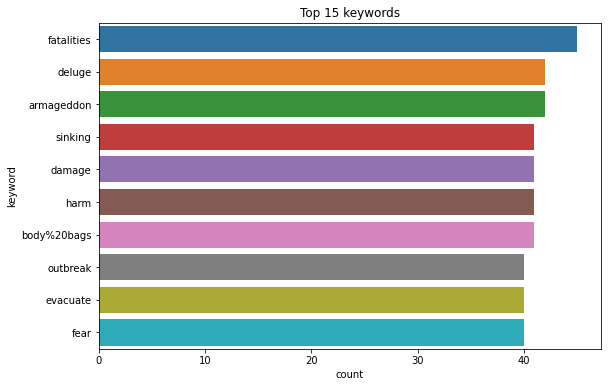

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(y=data.keyword, order = data.keyword.value_counts().head(10).index)
plt.title('Top 15 keywords')
plt.show()

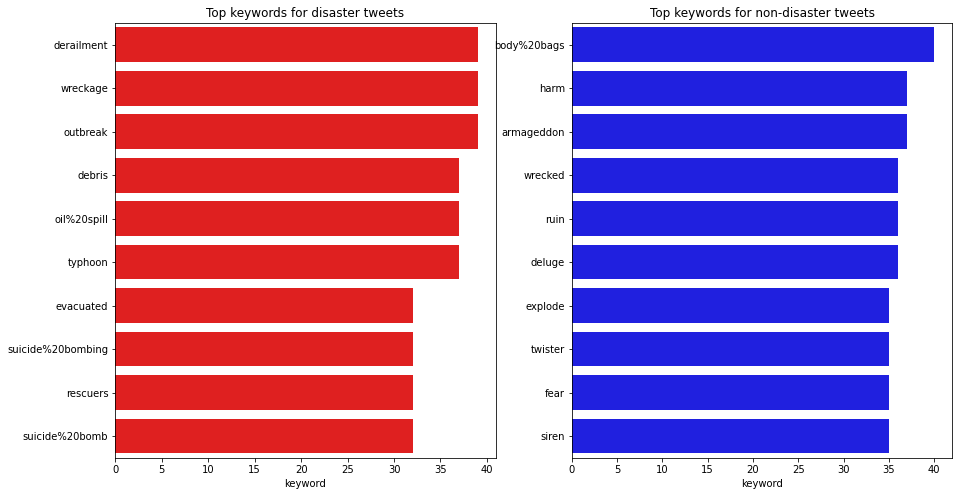

In [ ]:
kw_d = data[data.target==1].keyword.value_counts().head(10)
kw_nd = data[data.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(15,8))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='r')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='b')
plt.title('Top keywords for non-disaster tweets')
plt.show()

- Nous pouvons clairement voir que les principaux mots de ce dataset sont principalement liés à un accident, une catastrophe ou un décès.

# NLP Preprocessing & cloud of words



In [13]:
# let's take the columns we're interested in
data.drop(['id', 'keyword','location'], axis=1, inplace = True)
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [18]:
print("*** No disaster tweets ***")
for i in range(10) :
    print(data[data['target'] == 0].iloc[i])

print()
print("*** Disaster tweets ***")
for i in range(10) :
    print(data[data['target'] == 1].iloc[i])

*** No disaster tweets ***
text      What's up man?
target                 0
Name: 15, dtype: object
text      I love fruits
target                0
Name: 16, dtype: object
text      Summer is lovely
target                   0
Name: 17, dtype: object
text      My car is so fast
target                    0
Name: 18, dtype: object
text      What a goooooooaaaaaal!!!!!!
target                               0
Name: 19, dtype: object
text      this is ridiculous....
target                         0
Name: 20, dtype: object
text      London is cool ;)
target                    0
Name: 21, dtype: object
text      Love skiing
target              0
Name: 22, dtype: object
text      What a wonderful day!
target                        0
Name: 23, dtype: object
text      LOOOOOOL
target           0
Name: 24, dtype: object

*** Disaster tweets ***
text      Our Deeds are the Reason of this #earthquake M...
target                                                    1
Name: 0, dtype: object
text      F

- on peut voir que le vocabulaire n'est évidemment pas le même, les tweets semblent avoir plus de caractères, l'utilisation de # est plus importante dans les tweets.

In [ ]:
!python -m spacy download en_core_web_sm -q
import en_core_web_sm
# spacy and english initialisation
nlp = en_core_web_sm.load()
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

     |████████████████████████████████| 12.0 MB 5.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:

emoji_pattern = u"\U0001F600-\U0001F64F]+"
data["text_clean"] = data["text"].apply(lambda x:re.sub(emoji_pattern, '', x))
#supprime les url
data["text_clean"] = data["text_clean"].apply(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x, flags=re.MULTILINE))
# supprime les caractères spéciaux
data["text_clean"] = data["text_clean"].apply(lambda x: re.sub(r'\W', ' ', x))
# supprime les doubles espaces 
data["text_clean"] = data["text_clean"].apply(lambda x:re.sub(r'\s+', ' ', x))
# supprime les /n ou autre
data["text_clean"] = data["text_clean"].apply(lambda x:re.sub("\s+"," ",x).lower().strip())
# supprimer les chiffres 
data["text_clean"] = data["text_clean"].apply(lambda x:re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b","",x ))
# supprime les majuscules
data['text_clean'] = data['text_clean'].fillna('').apply(lambda x: x.lower())
#supprime tous les caractères de nos chaînes qui ne sont pas alphanumériques
data['text_clean']= data["text_clean"].apply(lambda x:[element for element in x if element.isalnum() or element==" "])
data['text_clean']=data["text_clean"].apply(lambda x:"".join([element for element in x if element.isalnum() or element==" "]))
#supprime les éléments atypiques
data["text_clean"] = data["text_clean"].str.replace('û', '').str.replace(' s ','').str.replace(' amp ','').str.replace(' rt ','')
#supprime tous les stop_word
STOP_WORDS.update(['new','news','m','like','don t',' rt ',' a ',' t ',' don ','think','know','day'])
data["text_clean"] = data["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))



In [ ]:
data.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order cal...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


- nous avons retiré tous les caractères qui ne sont pas alphanumériques, les chiffres, les majuscules, les doubles espaces, les caractères spéciaux, ainsi que les URL et les stop_word qui sont des mots sans aucune valeur ce qui permettra au modèle de ne pas être dérouté.

In [ ]:
#lemmatisation 
data['text_clean']=data["text_clean"].apply(lambda x:[token.lemma_ for token in nlp(x) if token.lemma_ not in STOP_WORDS and token.text not in STOP_WORDS])


- Nous allons également faire la lemmatisation pour que notre modèle reconnaisse la racine de nos mots qu'ils soient conjugués ou non.

In [ ]:
# using tf.keras.preprocessing.text.Tokenizer process to encoding all the reviews
# instanciate the tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(data.text_clean)
# Tokenization + Encoding
data["text_clean_encoded"] = tokenizer.texts_to_sequences(data.text_clean)
data["len_text_clean"] =data["text_clean_encoded"].apply(lambda x: len(x))
data =data[data["len_text_clean"]!=0]
data.head()

,text,target,text_clean,text_clean_encoded,len_text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,"[deed, reason, earthquake, allah, forgive]","[395, 197]",2
1,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, canada]","[129, 2, 156, 572]",4
2,All residents asked to 'shelter in place' are ...,1,"[resident, ask, shelter, place, notify, office...","[486, 324, 280, 171, 324, 270, 361]",7
3,"13,000 people receive #wildfires evacuation or...",1,"[ , people, receive, wildfire, evacuation, or...","[3, 4, 68, 171, 270, 32]",6
4,Just got sent this photo from Ruby #Alaska as ...,1,"[send, photo, ruby, alaska, smoke, wildfire, p...","[183, 111, 184, 68, 101]",5


- Nous allons maintenant passer par une phase de Tokenisation. Autrement dit, nous allons attribuer un numéro à chacun des mots présents dans nos tweets et les représenter par des séquences.

In [ ]:
#Un réseau de neurones nécessite d'avoir des entrées de même longueur nous allons également mettre une couche de padding pour que toutes les phrases ont la même taille
#(avec l'argument post la valeur padding = 0, est ajoutée à la fin des séquences).
text_pad = tf.keras.preprocessing.sequence.pad_sequences(data.text_clean_encoded, padding="post")


In [ ]:
# as Tensorflow is incapable to create a tensor dataset based on lists, we need to store all our encoded texts into a single numpy array before creating the tensorflow dataset
# furthermore, we also need to use the pad_sequences to add zero padding at the beginning or at the end of our sequences so they all have equal length
text_pad = tf.keras.preprocessing.sequence.pad_sequences(data.text_clean_encoded, padding="post")
full_ds = tf.data.Dataset.from_tensor_slices((text_pad, data.target.values))

In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7*data.shape[0])
# .shuffle() allows to randomly split the train and the test sets
# .batch on both sets to organise them by batches of XX observations

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

- On crée également en tensor puis nous allons mélanger les données après la création du test et du train grâce au shuffle. Il doit être supérieur au nombre de données de notre dataset pour éviter d'avoir des données rangées, sinon ils risquent de mettre des informations du train dans le test, ce que nous ne voulons surtout pas.

Look at a bach of Data

In [ ]:
# Regardons un batch 
for tweets, target in train_data.take(1):
  print(tweets, target)

tf.Tensor(
[[  3 825 374  31 941   0   0   0   0   0   0   0   0   0   0]
 [353 112 477 373 726 439 681 353 112 477 862   0   0   0   0]
 [ 35 465 203 346   0   0   0   0   0   0   0   0   0   0   0]
 [ 71  39 211  37 489   1 137   0   0   0   0   0   0   0   0]
 [577   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [507 278 143 423 346   0   0   0   0   0   0   0   0   0   0]
 [ 40 440 165  40  12 268 576   0   0   0   0   0   0   0   0]
 [126 413  12 147 235 521 126 186  12 695 125 946   0   0   0]
 [985 284 269 335 112   0   0   0   0   0   0   0   0   0   0]
 [405 190 311   2 387 125  32   0   0   0   0   0   0   0   0]
 [574  84 439 193 134 189  99   0   0   0   0   0   0   0   0]
 [142 275 114 132 381   0   0   0   0   0   0   0   0   0   0]
 [195 774   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [768 924   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [213 330 127 132  91   0   0   0   0   0   0   0   0   0   0]
 [403  46  56 403  46   0   0   0   0   0   

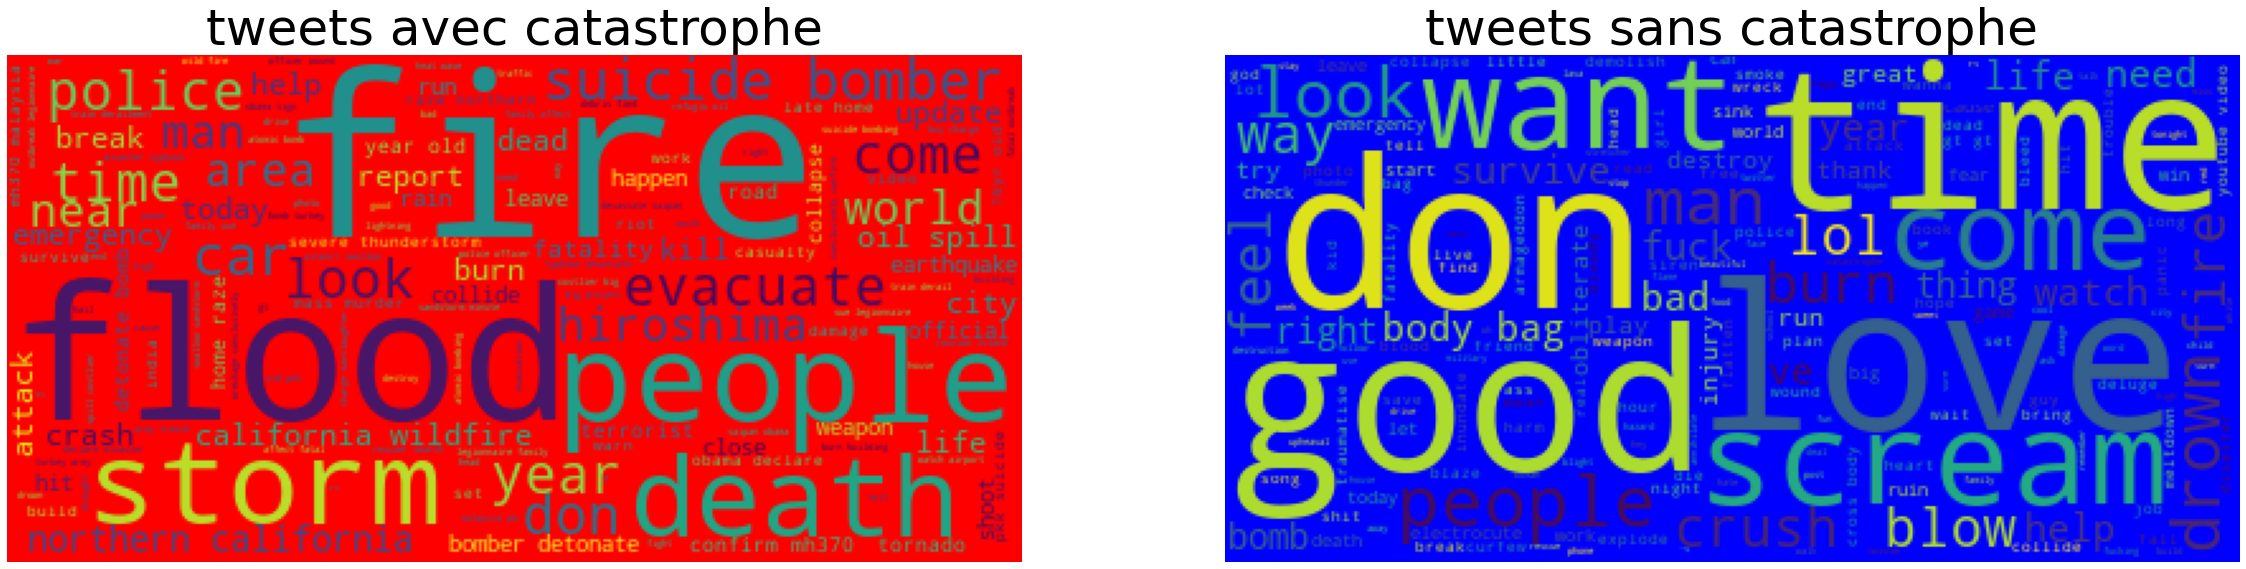

In [ ]:
import wordcloud
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(40, 40))

wd = wordcloud.WordCloud(background_color='red',
                         stopwords=STOP_WORDS)
cloud_desastre = wd.generate(' '.join(' '.join(text) for text in data[data.target==1]['text_clean']))

wn = wordcloud.WordCloud(background_color='blue',
                         stopwords=STOP_WORDS)
cloud_non_desastre = wn.generate(' '.join(' '.join(text) for text in data[data.target==0]['text_clean']))

ax1.imshow(cloud_desastre)
ax1.set_title("tweets avec catastrophe", fontsize=50)
ax1.axis('off')

ax2.imshow(cloud_non_desastre)
ax2.set_title("tweets sans catastrophe", fontsize=50)
ax2.axis('off')

fig.show()

- Grâce à cette visualisation en nuage de mots, on constate les différents mots qui sont représentés en tant que désastre en rouge et qui ne sont pas considérés comme tels en bleu.

# Classification Modeling


**LSTMs (Long Short Term Memory networks)**


Nous allons utiliser un réseau de neuronne artificiel pour que notre modèle soit capable d'apprendre par lui même contrairement à la programmation ou elle se contente d'exécuter à la lettre les régles prédeterminées.



In [ ]:
vocab_size = tokenizer.num_words
# text.shape[1] = df.len_text.max()

model = tf.keras.Sequential(
    [
     # input word embedding layer
     Embedding(vocab_size, 128, input_shape=[tweets.shape[1],], name="embedding"),
     
     # first layer LSTM, maintains the sequential nature
     LSTM(units=128, return_sequences=True),
     
     # second layer LSTM, returns the last output
     LSTM(units=64, return_sequences=False),
     
     # classical dense layer once the data is flat
     Dense(32, activation='relu'),
     Dense(16, activation='relu'),
     
     # dropout layer to prevent from overfitting
      Dropout(rate=0.3),
     
     # output layer with as many neurons as the number of classes (in our case one so activation function is sigmoid)
     Dense(1, activation="sigmoid", name="output_layer")
    ]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 128)           128000    
                                                                 
 lstm (LSTM)                 (None, 15, 128)           131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 output_layer (Dense)        (None, 1)                 1

In [ ]:
# Using a simple compiler with an Adam optimizer to calculate our gradients 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # metrics=['accuracy']
)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Model training
history= model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
83/83 [==============================] - 12s 89ms/step - loss: 0.5780 - binary_accuracy: 0.6978 - val_loss: 0.5348 - val_binary_accuracy: 0.7420
Epoch 2/20
83/83 [==============================] - 7s 84ms/step - loss: 0.4404 - binary_accuracy: 0.8129 - val_loss: 0.5125 - val_binary_accuracy: 0.7584
Epoch 3/20
83/83 [==============================] - 6s 72ms/step - loss: 0.4174 - binary_accuracy: 0.8270 - val_loss: 0.6158 - val_binary_accuracy: 0.7089
Epoch 4/20
83/83 [==============================] - 6s 71ms/step - loss: 0.4006 - binary_accuracy: 0.8324 - val_loss: 0.5704 - val_binary_accuracy: 0.7354
Epoch 5/20
83/83 [==============================] - 6s 78ms/step - loss: 0.3830 - binary_accuracy: 0.8442 - val_loss: 0.5817 - val_binary_accuracy: 0.7288
Epoch 6/20
83/83 [==============================] - 7s 79ms/step - loss: 0.3836 - binary_accuracy: 0.8453 - val_loss: 0.6056 - val_binary_accuracy: 0.7010
Epoch 7/20
83/83 [==============================] - 6s 78ms/step - lo

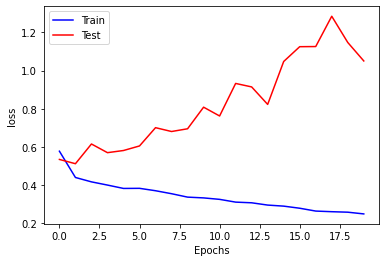

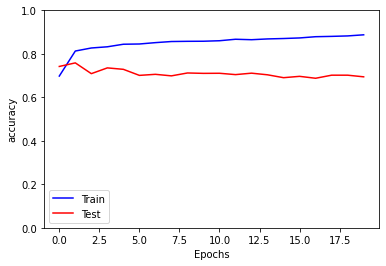

In [ ]:

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b",label = "Train")
plt.plot(history.history["val_loss"], color="r",label = "Test")
plt.legend()
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# Visualization of accuracy training 
plt.plot(history.history["binary_accuracy"], color="b",label = "Train")
plt.plot(history.history["val_binary_accuracy"], color="r",label = "Test")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.ylim([0, 1])

plt.show()

**Fight overfitting**

- optimize the model by reducing overfitting with L2 Regularization and the Dropout technique

In [ ]:
from keras import regularizers

vocab_size = tokenizer.num_words
# text.shape[1] = df.len_text.max()

model = tf.keras.Sequential(
    [
     # input word embedding layer
     Embedding(vocab_size, 128, input_shape=[tweets.shape[1],], name="embedding"),
    
     # first layer LSTM, maintains the sequential nature
     LSTM(units=128, return_sequences=True),
     
     # second layer LSTM, returns the last output
     LSTM(units=64, return_sequences=False),
     
     # classical dense layer once the data is flat
     Dense(32, activation='relu'),
     #Dense(16, activation='relu'),
     Dense(16, activation = 'relu', kernel_regularizer=regularizers.l2(0.0001)),
     # dropout layer to prevent from overfitting
      Dropout(rate=0.4),
     
     # output layer with as many neurons as the number of classes (in our case one so activation function is sigmoid)
     Dense(1, activation="sigmoid", name="output_layer")
    ]
)


In [ ]:
# Using a simple compiler with an Adam optimizer to calculate our gradients 
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
    # metrics=['accuracy']
)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")
# Model training
history= model.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    callbacks=[tensorboard_callback]
)

Epoch 1/20
83/83 [==============================] - 12s 91ms/step - loss: 0.5935 - binary_accuracy: 0.6893 - val_loss: 0.5173 - val_binary_accuracy: 0.7420
Epoch 2/20
83/83 [==============================] - 6s 71ms/step - loss: 0.4538 - binary_accuracy: 0.8105 - val_loss: 0.5252 - val_binary_accuracy: 0.7385
Epoch 3/20
83/83 [==============================] - 7s 85ms/step - loss: 0.4229 - binary_accuracy: 0.8323 - val_loss: 0.5611 - val_binary_accuracy: 0.7420
Epoch 4/20
83/83 [==============================] - 7s 80ms/step - loss: 0.4006 - binary_accuracy: 0.8402 - val_loss: 0.6351 - val_binary_accuracy: 0.7120
Epoch 5/20
83/83 [==============================] - 7s 80ms/step - loss: 0.3848 - binary_accuracy: 0.8453 - val_loss: 0.5668 - val_binary_accuracy: 0.7195
Epoch 6/20
83/83 [==============================] - 6s 72ms/step - loss: 0.3761 - binary_accuracy: 0.8476 - val_loss: 0.7714 - val_binary_accuracy: 0.6935
Epoch 7/20
83/83 [==============================] - 7s 80ms/step - lo

- Nous commençons par initialiser notre réseau de neuronnes avec Sequential qui regroupe une pile linéaire de calculs
- Avec une première couche d'embeding qui est parfaite pour les données textuelles. La couche d'embeding nous permet de faire une sortie arbitraire et de convertir les mots en vecteur continu qui va aider à l'apprentissage de notre modèle.
- nous utiliserons une sigmoïde car elle lisse les valeurs de sortie qui sont comprises entre 0 et 1 normalisant les sorties de chaque neuronne. Elle est donc identique à notre target et parfaite pour avoir des prédictions claires.
- Nous avons initialisé un nombre d'epoch à 20 notre modèle va donc regarder et apprendre de chaque batch que nous avons initialisé avant. Une fois qu'il aura regardé les 64 batch cela correspondra à une epoch. On remarque également que notre modèle apprend assez rapidement en regardant l'accuracy. 12 epoch lui suffisent pour apprendre correctement au-delà notre modèle n'apprend plus, l'accuracy stagne on obtient donc une accuracy à 0.86%.
- On remarque également la val_loss qui est la valeur de la fonction de coût pour nos données de validation croisée et la loss est la valeur de la fonction de coût pour vos données d'entraînement. Notre modèle essai donc de minimiser ces 2 metrics. 
- Afin de minimiser cette distance, le réseau de neurones apprend également en ajustant les poids et les biais de manière à réduire la perte.

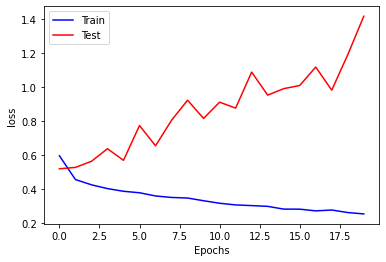

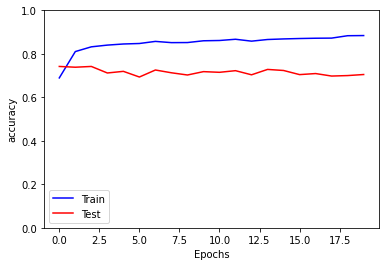

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b",label = "Train")
plt.plot(history.history["val_loss"], color="r",label = "Test")
plt.legend()
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

# Visualization of accuracy training 
plt.plot(history.history["binary_accuracy"], color="b",label = "Train")
plt.plot(history.history["val_binary_accuracy"], color="r",label = "Test")
plt.legend()
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.ylim([0, 1])

plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_true = (data["target"].values)
y_pred = model.predict(text_pad)
y_pred = [0 if x <= 0.5 else 1 for x in y_pred]
target_names = ['1', '0']
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      4284
           1       0.86      0.75      0.80      3262

    accuracy                           0.84      7546
   macro avg       0.84      0.83      0.83      7546
weighted avg       0.84      0.84      0.84      7546



- La précision du modèle lorsqu'il dit qu'un échantillon est non desaster et desaster à 83%.
- Concernant le recall il mesure la capacité du modèle à détecter des échantillons positifs. Nous avons un recall à 91% et 75%, cela signifie que nous avons 91% pour la classe 0 et 75% pour la classe 1 que nous arrivons à bien prédire comme 1 et 0, donc on peut faire confiance au modèle dans sa capacité à détecter des échantillons positifs.
- Le F1-score prend en compte la moyenne du déséquilibre entre le recall et la précision avec un F1-score à 87% montre l'exactitude de nos 2 metriques précédentes.

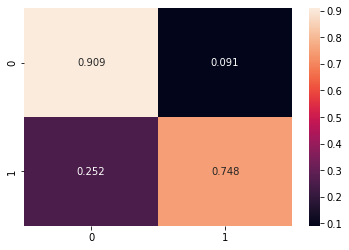

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_true, y_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");

# Conclusion 
- L'ensemble de données utilisé contient la majorité des événements situés aux États-Unis, au Royaume-Uni 
- Notre modèle nous donne une précision d'environ 86% ce qui montre que ces tweets parlent d'une catastrophe.